# TensowFlow のチュートリアル
## For Expert
参考
* http://qiita.com/haminiku/items/36982ae65a770565458d
* http://www.tensorflow.org/tutorials/mnist/beginners/index.html
 * official
* http://qiita.com/KojiOhki/items/64a2ee54214b01a411c7
 * 公式ドキュメントを訳してくれている

## 概要
* 畳込みニューラルネットでDeepLearningする
* 対象はMNIST手書き文字の認識

## 事前準備
* 事前にMNISTのデータを取得するためのclassを作っておく必要がある
 * input_data.py

## MNIST手書き文字認識の実装
### 準備
#### 必要パッケージのインポート

In [1]:
from __future__ import absolute_import, unicode_literals
import input_data
import tensorflow as tf

## 学習結果の描画に使う
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### データのセット
* input_dataパッケージを使うと、未ダウンロードの場合は自動的にダウンロードして、オブジェクト作ってくれる（ちょっと時間かかる）
* ダウンロード済みの場合は、メモリにロードしてオブジェクト作るだけ（速い）

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### セッションクラスのインスタンスを生成
* TensorFlowではバックでC++使って高速に計算させる。
* バッグエンドとのやり取りするために、「セッション」を作成する
* InteractiveSessionクラスを使う。
 * computation graphを実行する間に、computation graphを作れる? 良さがよくわからん。
 * computation graphの項目を確認した方が良いかも

In [3]:
sess = tf.InteractiveSession()


#### Placeholders

In [4]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

### Build a Multilayer Convolutional Network
* Beginner編で単層のソフトマックス回帰を作った結果、精度は91%くらいだった
 * これは明らかに悪い。MNISTの文字認識なら通常99%くらいは達成しておきたい。ということらしい。
* そこで、このチュートリアルでは、シンプルな畳込みニューラルネットを使って文字認識させてみる

#### 重みを初期化する
* DeepLearningはNNをDeepにするのでたくさんの重みが必要になる
* 初期値は0にするのではなくて、小さいノイズを載せた方が良いって書いてある。
* バイアスについても、活性化関数にReluを使うので正のノイズを加えるべきだって書いてある。
 * 勾配がいきなり0にならないようにみたいなことが書いてあるけど、あんまりよくわかっていない

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


#### Convolution and Pooling
* 畳込み層：入力と出力が同じになるように0でパディングする(足りない部分に0入れるってことでいい?)
* プーリング層：2×2の古典的なプーリング設定とする
 * プーリング層 → 畳込み画像に対してプーリング演算する。
 * 2×2のピクセルの最大値をとって一つのピクセルに変換する。これをすることで特徴量の位置変化によく追従できるらしい
 * プーリングには、Max poolingとAverage poolingってのはあるらしい。↑はmax pooling最大値ではなく、平均をとるのがaverage pooling

In [6]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


#### First Convolutional Layer 第1層の畳込み層の定義
* 畳込みのパッチサイズは5×5にする
* 入力チャネルは、グレースケール画像で1チャネル
* 出力チャネルは32
 * この辺りが良くわかってないので、調べる。畳込みニューラルネットの基本。


In [7]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

* ↑の畳込み層を実装するために、入力データxを4次元テンソルに変換する
 * [-1, image_width, image_height, color_channel]

In [8]:
x_image = tf.reshape(x, [-1,28,28,1])

* 畳込み層とプーリング層の定義

In [9]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#### Second Convolutional Layer 第2層の畳込み層（Deep!）
* 第2層では、第1層の出力チャネルが32で、この層の出力チャネル64にするので、以下のように設定する

In [10]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


#### Densely Connected Layer 
* 全結合層
* 普通のNNの層が最後に来る
 * だと思っている

In [11]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#### Dropout
* 過学習防ぐための手段

In [12]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

##### 出力層
* クラス分類タスクなので、softmax回帰して、出力とする

In [13]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

### Train and Evaluate the Model
* ここまでで、モデルの定義ができたので、後は訓練と評価をやろう
* 基本的には、Beginner編の単層NNモデルと同じようにやれば良い
* ここでは、最適化計算をADAMで実装する

In [14]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess.run(tf.initialize_all_variables())


In [15]:
test_step = []
train_acc  = []
test_acc = []

for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i % 10 == 0:
        # 訓練データでの精度
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
        # テストデータでの精度
        idxs = np.random.permutation(len(mnist.test.images))[:1000]
        acc = accuracy.eval(feed_dict={x: mnist.test.images[idxs,], y_: mnist.test.labels[idxs,], keep_prob: 1.0})
        # 評価結果の保存
        test_step.append(i+1)
        train_acc.append(train_accuracy)
        test_acc.append(acc)
        print "step %d, training accuracy %g" % (i, train_accuracy)
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})


step 0, training accuracy 0.1
step 10, training accuracy 0.12
step 20, training accuracy 0.38
step 30, training accuracy 0.54
step 40, training accuracy 0.62
step 50, training accuracy 0.62
step 60, training accuracy 0.7
step 70, training accuracy 0.76
step 80, training accuracy 0.84
step 90, training accuracy 0.76
step 100, training accuracy 0.8
step 110, training accuracy 0.8
step 120, training accuracy 0.92
step 130, training accuracy 0.82
step 140, training accuracy 0.88
step 150, training accuracy 0.82
step 160, training accuracy 0.76
step 170, training accuracy 0.88
step 180, training accuracy 0.86
step 190, training accuracy 0.76
step 200, training accuracy 0.92
step 210, training accuracy 0.9
step 220, training accuracy 0.84
step 230, training accuracy 0.96
step 240, training accuracy 0.86
step 250, training accuracy 0.84
step 260, training accuracy 0.92
step 270, training accuracy 0.96
step 280, training accuracy 0.94
step 290, training accuracy 0.88
step 300, training accurac

### 学習結果の確認
#### テストデータによる認識精度

In [16]:
idxs = np.random.permutation(len(mnist.test.images))[:1000]
acc = accuracy.eval(feed_dict={x: mnist.test.images[idxs,], y_: mnist.test.labels[idxs,], keep_prob: 1.0})
print "test accuracy %g"%acc

test accuracy 0.964


#### 学習曲線

(-10, 1991)

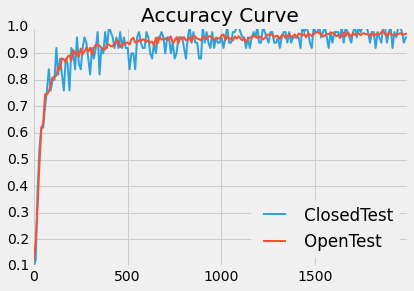

In [17]:
plt.style.use('fivethirtyeight')
plt.plot(test_step, train_acc, linewidth=2.0, label="ClosedTest")
plt.plot(test_step, test_acc, linewidth=2.0, label="OpenTest")
plt.legend(loc='lower right')
plt.title("Accuracy Curve")
plt.xlim(-10, np.max(test_step))

#### 文字認識の例

In [18]:
size = 28
col = 5
row = 3
plt.figure(figsize=(20, 3))

# 描画用の関数
def draw_digit(data, n, ans, recog):
    plt.subplot(row, col, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # 見やすいように反転させる
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(Z)  # 指定座標(X,Y)にカラープロット(色=Z)する
    plt.title("ans=%d, recog=%d"%(ans,recog), size=8)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

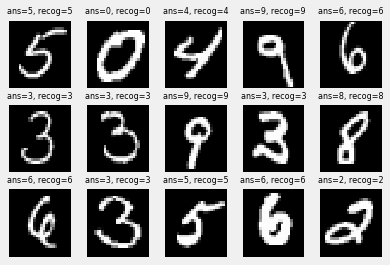

In [19]:
N = len(mnist.test.images)

cnt = 0
for idx in np.random.permutation(N)[:col*row]:
    rec = sess.run(tf.argmax(y_conv,1), feed_dict={x: mnist.test.images[idx:idx+1,], y_: mnist.test.labels[idx:idx+1,], keep_prob: 1.0})
    cnt+=1
    draw_digit(mnist.test.images[idx], cnt, np.argmax(mnist.test.labels[idx]), rec)
plt.show()
